✅ Estações 4G LTE (faixas 700/2500, período correto): 103,290
✅ Municípios únicos: 4,612
✅ Período: 2012-01-01 00:00:00 a 2022-12-01 00:00:00

=== DISTRIBUIÇÃO POR FAIXA E ANO ===

Faixa 2500 MHz:
ano
2012.0     3572
2013.0     3266
2014.0     4669
2015.0     5635
2016.0    21552
2017.0     7508
2018.0     5108
2019.0     4703
2020.0     2269
2021.0     4906
2022.0     5136
Name: count, dtype: int64

Faixa 700 MHz:
ano
2015.0    6013
2016.0    3301
2017.0    3012
2018.0    3857
2019.0    4070
2020.0    2774
2021.0    5787
2022.0    6152
Name: count, dtype: int64

=== CRIANDO DATASET MUNICIPAL ===

✅ Total de municípios com 4G: 4,612
✅ Período: 2012-01-01 00:00:00 a 2022-12-01 00:00:00

=== MUNICÍPIOS POR ANO (PRIMEIRA ESTAÇÃO 4G) ===
ano_primeira_4g
2012    525
2013    243
2014    336
2015    858
2016    277
2017    268
2018    353
2019    188
2020    280
2021    642
2022    642
Name: count, dtype: int64

=== ESTATÍSTICAS POR CICLO ELEITORAL ===
Antes Eleição 2014 (até Set/2014): 971 m

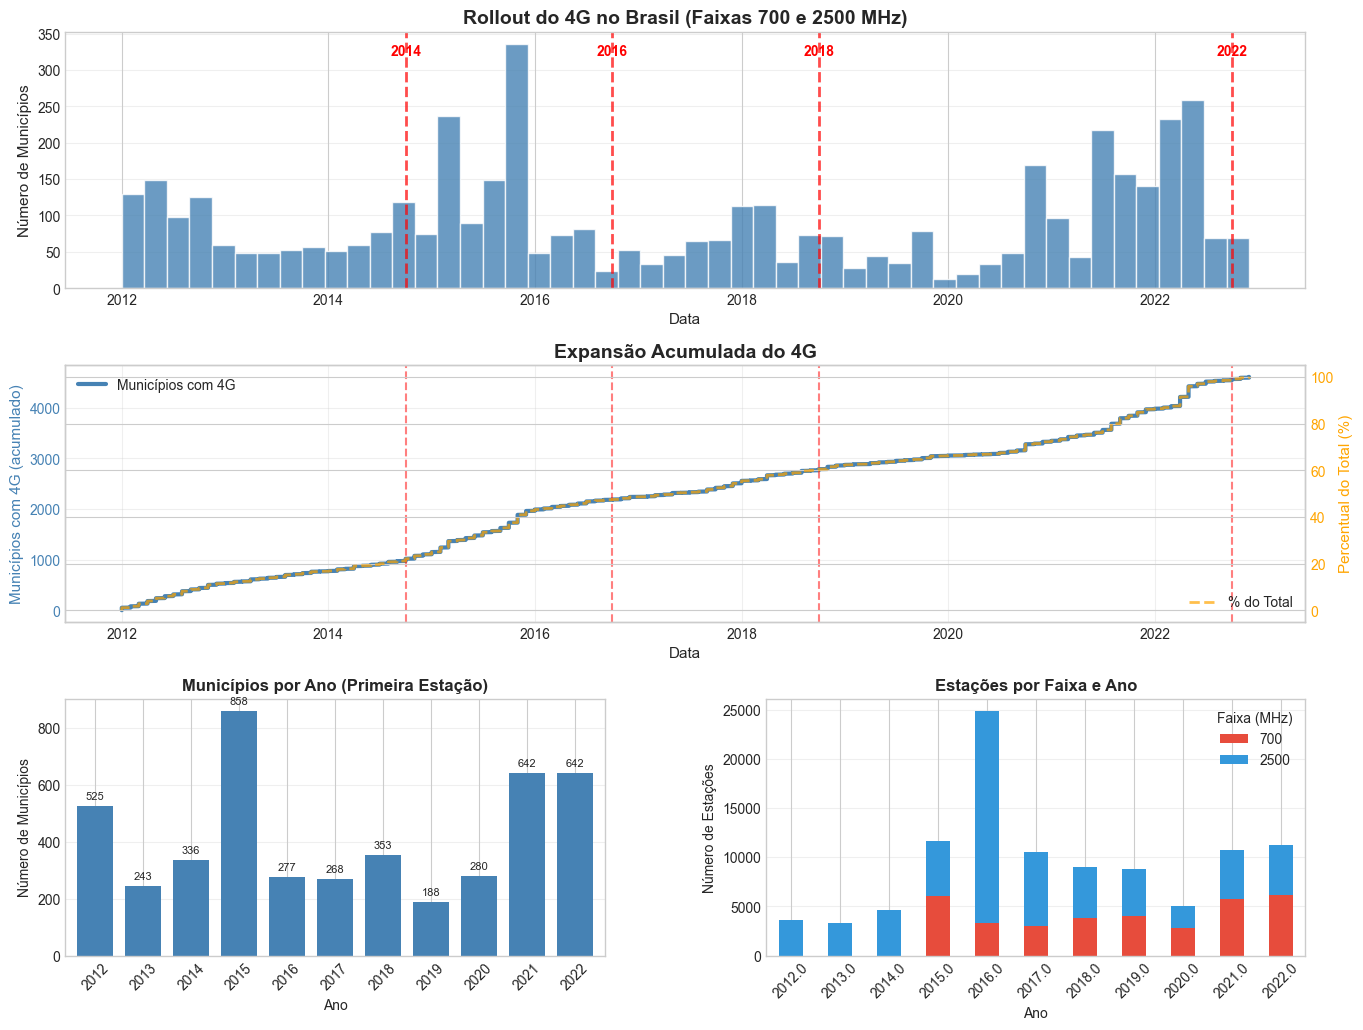


=== SALVANDO DADOS LIMPOS ===
✅ Arquivo salvo: municipios_4g_limpo_final.csv
✅ Arquivo salvo: resumo_4g_limpo_final.txt

✅ ANÁLISE COMPLETA COM DADOS LIMPOS!

Arquivos gerados:
  1. municipios_4g_limpo_final.csv
  2. resumo_4g_limpo_final.txt
  3. analise_4g_limpa_final.png



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# 1. DADOS ANATEL
# ============================================

# Carregar dados
anatel = pd.read_csv('Estacoes_SMP.csv', encoding='utf-8', sep=';', low_memory=False)

# Filtrar 4G com faixas puras
anatel_4g_clean = anatel[
    (anatel['Geração'] == '4G') &
    (anatel['Tecnologia'] == 'LTE') &
    (anatel['Faixa Estação'].isin([700, 2500]))
].copy()

# Converter data
anatel_4g_clean['data_lic'] = pd.to_datetime(anatel_4g_clean['AnoMesLic'], format='%Y-%m')
anatel_4g_clean['ano'] = anatel_4g_clean['data_lic'].dt.year

# Aplicar filtros temporais por faixa
anatel_4g_clean = anatel_4g_clean[
    ((anatel_4g_clean['Faixa Estação'] == 2500) & (anatel_4g_clean['data_lic'] >= '2012-01-01')) |
    ((anatel_4g_clean['Faixa Estação'] == 700) & (anatel_4g_clean['data_lic'] >= '2015-01-01'))
]

# Filtrar até 2022 (última eleição com dados disponíveis)
anatel_4g_clean = anatel_4g_clean[anatel_4g_clean['data_lic'] <= '2022-12-31']

print(f"✅ Estações 4G LTE (faixas 700/2500, período correto): {len(anatel_4g_clean):,}")
print(f"✅ Municípios únicos: {anatel_4g_clean['Código IBGE'].nunique():,}")
print(f"✅ Período: {anatel_4g_clean['data_lic'].min()} a {anatel_4g_clean['data_lic'].max()}")

print("\n=== DISTRIBUIÇÃO POR FAIXA E ANO ===")
print("\nFaixa 2500 MHz:")
faixa_2500 = anatel_4g_clean[anatel_4g_clean['Faixa Estação'] == 2500]
print(faixa_2500['ano'].value_counts().sort_index())

print("\nFaixa 700 MHz:")
faixa_700 = anatel_4g_clean[anatel_4g_clean['Faixa Estação'] == 700]
print(faixa_700['ano'].value_counts().sort_index())

# Criar dataset municipal
municipios_4g = anatel_4g_clean.groupby('Código IBGE').agg({
    'data_lic': 'min',
    'Código IBGE': 'count',
    'Município-UF': 'first',
    'UF': 'first',
    'Empresa Estação': 'first',
    'Faixa Estação': lambda x: x.iloc[0]  # Faixa da primeira estação
}).reset_index(drop=True)

municipios_4g.columns = ['primeira_estacao_4g', 'n_estacoes_4g_total', 
                          'Município-UF', 'UF', 'operadora_primeira', 
                          'faixa_primeira']

municipios_4g.insert(0, 'Código IBGE', 
                     anatel_4g_clean.groupby('Código IBGE')['Código IBGE'].first().values)

municipios_4g['ano_primeira_4g'] = municipios_4g['primeira_estacao_4g'].dt.year
municipios_4g['mes_primeira_4g'] = municipios_4g['primeira_estacao_4g'].dt.month
municipios_4g['trimestre_primeira_4g'] = municipios_4g['primeira_estacao_4g'].dt.quarter

municipios_4g = municipios_4g.sort_values('primeira_estacao_4g').reset_index(drop=True)

print(f"\n✅ Total de municípios com 4G: {len(municipios_4g):,}")
print(f"✅ Período: {municipios_4g['primeira_estacao_4g'].min()} a {municipios_4g['primeira_estacao_4g'].max()}")

print("\n=== MUNICÍPIOS POR ANO (PRIMEIRA ESTAÇÃO 4G) ===")
mun_por_ano = municipios_4g['ano_primeira_4g'].value_counts().sort_index()
print(mun_por_ano)

print("\n=== ESTATÍSTICAS POR CICLO ELEITORAL ===")
ciclos = {
    'Antes Eleição 2014 (até Set/2014)': len(municipios_4g[municipios_4g['primeira_estacao_4g'] < '2014-10-01']),
    'Entre 2014 e 2016 (Out/2014 - Set/2016)': len(municipios_4g[(municipios_4g['primeira_estacao_4g'] >= '2014-10-01') & 
                                                                   (municipios_4g['primeira_estacao_4g'] < '2016-10-01')]),
    'Entre 2016 e 2018 (Out/2016 - Set/2018)': len(municipios_4g[(municipios_4g['primeira_estacao_4g'] >= '2016-10-01') & 
                                                                   (municipios_4g['primeira_estacao_4g'] < '2018-10-01')]),
    'Entre 2018 e 2022 (Out/2018 - Dez/2022)': len(municipios_4g[municipios_4g['primeira_estacao_4g'] >= '2018-10-01'])
}

for ciclo, n_mun in ciclos.items():
    pct = (n_mun / len(municipios_4g)) * 100
    print(f"{ciclo}: {n_mun:,} municípios ({pct:.1f}%)")

print("\n=== PRIMEIROS 20 MUNICÍPIOS COM 4G ===")
print(municipios_4g[['Município-UF', 'primeira_estacao_4g', 'faixa_primeira', 'operadora_primeira']].head(20))


# Visualizações

# Configurar estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Figura com 4 subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Histograma temporal
ax1 = fig.add_subplot(gs[0, :])
municipios_4g['primeira_estacao_4g'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white', alpha=0.8)
for ano, label in [(2014, '2014'), (2016, '2016'), (2018, '2018'), (2022, '2022')]:
    ax1.axvline(pd.Timestamp(f'{ano}-10-01'), color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(pd.Timestamp(f'{ano}-10-01'), ax1.get_ylim()[1]*0.95, label, 
             ha='center', va='top', fontsize=10, fontweight='bold', color='red')
ax1.set_title('Rollout do 4G no Brasil (Faixas 700 e 2500 MHz)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Data', fontsize=11)
ax1.set_ylabel('Número de Municípios', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Subplot 2: Acumulado
ax2 = fig.add_subplot(gs[1, :])
municipios_sorted = municipios_4g.sort_values('primeira_estacao_4g').copy()
municipios_sorted['acumulado'] = range(1, len(municipios_sorted) + 1)
municipios_sorted['pct_acumulado'] = (municipios_sorted['acumulado'] / len(municipios_sorted)) * 100

ax2.plot(municipios_sorted['primeira_estacao_4g'], municipios_sorted['acumulado'], 
         linewidth=3, color='steelblue', label='Municípios com 4G')
ax2_twin = ax2.twinx()
ax2_twin.plot(municipios_sorted['primeira_estacao_4g'], municipios_sorted['pct_acumulado'], 
              linewidth=2, color='orange', linestyle='--', alpha=0.7, label='% do Total')

for ano in [2014, 2016, 2018, 2022]:
    ax2.axvline(pd.Timestamp(f'{ano}-10-01'), color='red', linestyle='--', linewidth=1.5, alpha=0.5)

ax2.set_title('Expansão Acumulada do 4G', fontsize=14, fontweight='bold')
ax2.set_xlabel('Data', fontsize=11)
ax2.set_ylabel('Municípios com 4G (acumulado)', fontsize=11, color='steelblue')
ax2_twin.set_ylabel('Percentual do Total (%)', fontsize=11, color='orange')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='orange')
ax2.grid(alpha=0.3)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='lower right')

# Subplot 3: Por ano (barras)
ax3 = fig.add_subplot(gs[2, 0])
mun_por_ano.plot(kind='bar', ax=ax3, color='steelblue', width=0.75)
ax3.set_title('Municípios por Ano (Primeira Estação)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano', fontsize=10)
ax3.set_ylabel('Número de Municípios', fontsize=10)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
for i, v in enumerate(mun_por_ano.values):
    if v > 0:
        ax3.text(i, v + max(mun_por_ano)*0.02, str(v), ha='center', va='bottom', fontsize=8)
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Por faixa ao longo do tempo
ax4 = fig.add_subplot(gs[2, 1])
faixa_ano = anatel_4g_clean.groupby(['ano', 'Faixa Estação']).size().unstack(fill_value=0)
faixa_ano.plot(kind='bar', stacked=True, ax=ax4, color=['#e74c3c', '#3498db'])
ax4.set_title('Estações por Faixa e Ano', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano', fontsize=10)
ax4.set_ylabel('Número de Estações', fontsize=10)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.legend(title='Faixa (MHz)', labels=['700', '2500'])
ax4.grid(axis='y', alpha=0.3)

plt.savefig('analise_4g_limpa_final.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico salvo: analise_4g_limpa_final.png")
plt.show()

# Salvar dados
municipios_4g.to_csv('municipios_4g_limpo_final.csv', index=False, encoding='utf-8-sig')
print("✅ Arquivo salvo: municipios_4g_limpo_final.csv")

# Estatísticas detalhadas
with open('resumo_4g_limpo_final.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("ANÁLISE DO ROLLOUT DO 4G NO BRASIL (DADOS LIMPOS)\n")
    f.write("Critério: Faixas 700 e 2500 MHz nos períodos corretos\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Total de estações 4G LTE: {len(anatel_4g_clean):,}\n")
    f.write(f"Total de municípios com 4G: {len(municipios_4g):,}\n")
    f.write(f"Período: {municipios_4g['primeira_estacao_4g'].min()} a {municipios_4g['primeira_estacao_4g'].max()}\n\n")
    
    f.write("Municípios por ano (primeira estação 4G):\n")
    f.write("-" * 40 + "\n")
    for ano, count in mun_por_ano.items():
        f.write(f"  {int(ano)}: {count:>4,} municípios\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("DISTRIBUIÇÃO POR CICLO ELEITORAL\n")
    f.write("="*70 + "\n")
    for ciclo, n_mun in ciclos.items():
        pct = (n_mun / len(municipios_4g)) * 100
        f.write(f"{ciclo}:\n")
        f.write(f"  {n_mun:,} municípios ({pct:.1f}% do total)\n\n")

print("✅ Arquivo salvo: resumo_4g_limpo_final.txt")

print("\n" + "="*70)
print("✅ ANÁLISE COMPLETA COM DADOS LIMPOS!")
print("="*70)
print("\nArquivos gerados:")
print("  1. municipios_4g_limpo_final.csv")
print("  2. resumo_4g_limpo_final.txt")
print("  3. analise_4g_limpa_final.png")
print("\n" + "="*70)

In [4]:
# ============================================
# 2. CARREGAR TABELA DE CORRESPONDÊNCIA TSE
# ============================================

# Ajuste o nome do arquivo conforme necessário
correspondencia_tse = pd.read_csv(
    'depara-ibge-tse.csv',  # ou o nome que você deu ao arquivo
    encoding='latin1',  # ou 'utf-8' se necessário
    sep=';'  # ajuste o delimitador se necessário
)

print(f"✅ Tabela TSE carregada: {len(correspondencia_tse)} registros")

# Ver estrutura
print("\nColunas disponíveis:")
print(correspondencia_tse.columns.tolist())

print("\nPrimeiras linhas:")
print(correspondencia_tse.head())

# Limpar e padronizar
correspondencia_tse = correspondencia_tse.rename(columns={
    'CD_MUNICIPIO_TSE': 'codigo_tse',
    'CD_MUNICIPIO_IBGE': 'codigo_ibge',
    'NM_MUNICIPIO_TSE': 'municipio_tse',
    'NM_MUNICIPIO_IBGE': 'municipio_ibge',
    'SG_UF': 'uf',
    'NM_UF': 'nome_uf'
})
# Selecionar colunas relevantes
correspondencia_tse = correspondencia_tse[[
    'codigo_tse', 'codigo_ibge', 'municipio_tse', 'municipio_ibge', 'uf', 'nome_uf'
]].copy()

# Garantir tipos corretos
correspondencia_tse['codigo_tse'] = correspondencia_tse['codigo_tse'].astype(int)
correspondencia_tse['codigo_ibge'] = correspondencia_tse['codigo_ibge'].astype(int)

# Verificar duplicatas
print(f"\n=== VERIFICAÇÕES ===")
print(f"Códigos TSE únicos: {correspondencia_tse['codigo_tse'].nunique()}")
print(f"Códigos IBGE únicos: {correspondencia_tse['codigo_ibge'].nunique()}")

duplicados_tse = correspondencia_tse['codigo_tse'].duplicated().sum()
duplicados_ibge = correspondencia_tse['codigo_ibge'].duplicated().sum()

print(f"Códigos TSE duplicados: {duplicados_tse}")
print(f"Códigos IBGE duplicados: {duplicados_ibge}")

if duplicados_tse > 0 or duplicados_ibge > 0:
    print("⚠️ ATENÇÃO: Há duplicatas! Removendo...")
    correspondencia_tse = correspondencia_tse.drop_duplicates(subset=['codigo_ibge'], keep='first')
    print(f"Após remoção: {len(correspondencia_tse)} registros")

✅ Tabela TSE carregada: 5571 registros

Colunas disponíveis:
['DT_GERACAO', 'HH_GERACAO', 'CD_UF_TSE', 'CD_UF_IBGE', 'SG_UF', 'NM_UF', 'CD_MUNICIPIO_TSE', 'NM_MUNICIPIO_TSE', 'CD_MUNICIPIO_IBGE', 'NM_MUNICIPIO_IBGE']

Primeiras linhas:
   DT_GERACAO HH_GERACAO  CD_UF_TSE  CD_UF_IBGE SG_UF NM_UF  CD_MUNICIPIO_TSE  \
0  19/10/2025   09:00:07         24          12    AC  Acre              1007   
1  19/10/2025   09:00:07         24          12    AC  Acre              1015   
2  19/10/2025   09:00:07         24          12    AC  Acre              1023   
3  19/10/2025   09:00:07         24          12    AC  Acre              1031   
4  19/10/2025   09:00:07         24          12    AC  Acre              1040   

       NM_MUNICIPIO_TSE  CD_MUNICIPIO_IBGE     NM_MUNICIPIO_IBGE  
0                Bujari            1200138                Bujari  
1              Capixaba            1200179              Capixaba  
2            Porto Acre            1200807            Porto Acre  
3   Santa

In [6]:
# ============================================
# 3. MERGER DADOS ANATEL - TSE
# ============================================

# Carregar dados 4G
municipios_4g = pd.read_csv('municipios_4g_limpo_final.csv')

print(f"Municípios com 4G: {len(municipios_4g)}")
print(f"Códigos IBGE únicos: {municipios_4g['Código IBGE'].nunique()}")

#Fazer merge
municipios_4g_tse = municipios_4g.merge(
    correspondencia_tse,
    left_on='Código IBGE',
    right_on='codigo_ibge',
    how='left',
    indicator=True
)

# Resultados do merge
print("\nResultados do merge:")
merge_stats = municipios_4g_tse['_merge'].value_counts()
print(merge_stats)

# Calcular taxa de match
matched = len(municipios_4g_tse[municipios_4g_tse['_merge'] == 'both'])
taxa_match = (matched / len(municipios_4g)) * 100
print(f"\n✅ Taxa de match: {taxa_match:.2f}%")

# Identificar municípios sem match
sem_match = municipios_4g_tse[municipios_4g_tse['_merge'] == 'left_only']

if len(sem_match) > 0:
    print(f"\n⚠️ {len(sem_match)} municípios SEM correspondência TSE ({100-taxa_match:.2f}%)")
    print("\nPrimeiros 20 sem match:")
    print(sem_match[['Código IBGE', 'Município-UF', 'UF', 'primeira_estacao_4g']].head(20))
    
    # Salvar lista completa
    sem_match[['Código IBGE', 'Município-UF', 'UF']].to_csv(
        'municipios_sem_correspondencia_tse.csv', 
        index=False,
        encoding='utf-8-sig'
    )
    print("Lista completa salva: municipios_sem_correspondencia_tse.csv")
    
    # Análise dos sem match
    print("\nDistribuição por UF dos municípios sem match:")
    print(sem_match['UF'].value_counts())
else:
    print("\n🎉 PERFEITO! 100% dos municípios têm correspondência TSE!")

# Manter apenas municípios com match
municipios_4g_tse = municipios_4g_tse[municipios_4g_tse['_merge'] == 'both'].copy()
municipios_4g_tse = municipios_4g_tse.drop(columns=['_merge'])

Municípios com 4G: 4612
Códigos IBGE únicos: 4612

Resultados do merge:
_merge
both          4612
left_only        0
right_only       0
Name: count, dtype: int64

✅ Taxa de match: 100.00%

🎉 PERFEITO! 100% dos municípios têm correspondência TSE!


In [7]:
# ============================================
# 4. CRIAR VARIÁVEIS DE TRATAMENTO
# ============================================

# Converter data para datetime se necessário
municipios_4g_tse['primeira_estacao_4g'] = pd.to_datetime(
    municipios_4g_tse['primeira_estacao_4g']
)

# Variáveis de tratamento por ano eleitoral
eleicoes = [2010, 2014, 2018, 2022]

for ano in eleicoes:
    # Dummy: tem 4G antes da eleição?
    data_eleicao = pd.Timestamp(f'{ano}-10-01')
    municipios_4g_tse[f'tem_4g_{ano}'] = (
        municipios_4g_tse['primeira_estacao_4g'] < data_eleicao
    ).astype(int)
    
    # Dose-response: há quantos anos tem 4G?
    municipios_4g_tse[f'anos_com_4g_{ano}'] = np.where(
        municipios_4g_tse[f'tem_4g_{ano}'] == 1,
        (data_eleicao - municipios_4g_tse['primeira_estacao_4g']).dt.days / 365.25,
        0
    )

# Mostrar distribuição
print("\nDistribuição de municípios com 4G por ano eleitoral:")
print("-" * 60)
for ano in eleicoes:
    n_tratados = municipios_4g_tse[f'tem_4g_{ano}'].sum()
    n_controle = len(municipios_4g_tse) - n_tratados
    pct_tratados = (n_tratados / len(municipios_4g_tse)) * 100
    
    print(f"{ano}:")
    print(f"  Com 4G (tratados): {n_tratados:>4,} ({pct_tratados:>5.1f}%)")
    print(f"  Sem 4G (controle): {n_controle:>4,} ({100-pct_tratados:>5.1f}%)")

# Estatísticas de anos com 4G (dose-response)
print("\n=== DOSE-RESPONSE: Anos com 4G ===")
for ano in [2014, 2018, 2022]:
    tratados = municipios_4g_tse[municipios_4g_tse[f'tem_4g_{ano}'] == 1]
    if len(tratados) > 0:
        media_anos = tratados[f'anos_com_4g_{ano}'].mean()
        max_anos = tratados[f'anos_com_4g_{ano}'].max()
        print(f"{ano}: média = {media_anos:.1f} anos, máximo = {max_anos:.1f} anos")



Distribuição de municípios com 4G por ano eleitoral:
------------------------------------------------------------
2010:
  Com 4G (tratados):    0 (  0.0%)
  Sem 4G (controle): 4,612 (100.0%)
2014:
  Com 4G (tratados):  971 ( 21.1%)
  Sem 4G (controle): 3,641 ( 78.9%)
2018:
  Com 4G (tratados): 2,764 ( 59.9%)
  Sem 4G (controle): 1,848 ( 40.1%)
2022:
  Com 4G (tratados): 4,543 ( 98.5%)
  Sem 4G (controle):   69 (  1.5%)

=== DOSE-RESPONSE: Anos com 4G ===
2014: média = 1.7 anos, máximo = 2.7 anos
2018: média = 3.6 anos, máximo = 6.7 anos
2022: média = 5.2 anos, máximo = 10.7 anos


In [8]:
# ============================================
# 5. ORGANIZAR E SALVAR DATASET FINAL
# ============================================

print("\n=== PREPARANDO DATASET FINAL ===")

# Selecionar e ordenar colunas
colunas_finais = [
    # Identificadores
    'codigo_tse', 'codigo_ibge', 'municipio_tse', 'uf', 'nome_uf',
    'Município-UF',  # Nome original da Anatel (para conferência)
    
    # Informações do 4G
    'primeira_estacao_4g', 'ano_primeira_4g', 'mes_primeira_4g',
    'n_estacoes_4g_total', 'operadora_primeira', 'faixa_primeira',
    
    # Variáveis de tratamento (dummies)
    'tem_4g_2010', 'tem_4g_2014', 'tem_4g_2018', 'tem_4g_2022',
    
    # Variáveis de dose-response
    'anos_com_4g_2014', 'anos_com_4g_2018', 'anos_com_4g_2022'
]

municipios_4g_tse_final = municipios_4g_tse[colunas_finais].copy()

# Ordenar por código TSE
municipios_4g_tse_final = municipios_4g_tse_final.sort_values('codigo_tse').reset_index(drop=True)

# Salvar
arquivo_saida = 'municipios_4g_com_codigo_tse.csv'
municipios_4g_tse_final.to_csv(arquivo_saida, index=False, encoding='utf-8-sig')

print(f"✅ Dataset final salvo: {arquivo_saida}")

# Estatísticas descritivas e visualização

print("\n" + "="*70)
print("RESUMO FINAL DO DATASET")
print("="*70)

print(f"\nTotal de municípios no dataset: {len(municipios_4g_tse_final):,}")
print(f"Taxa de match IBGE→TSE: {taxa_match:.2f}%")
print(f"Período de dados: {municipios_4g_tse_final['primeira_estacao_4g'].min().date()} a {municipios_4g_tse_final['primeira_estacao_4g'].max().date()}")

print("\n=== DISTRIBUIÇÃO GEOGRÁFICA ===")
print(municipios_4g_tse_final['uf'].value_counts().head(10))

print("\n=== PRIMEIRAS 10 LINHAS DO DATASET FINAL ===")
print(municipios_4g_tse_final.head(10).to_string())

# Verificação final de integridade
print("\n=== VERIFICAÇÕES DE INTEGRIDADE ===")
print(f"Códigos TSE únicos: {municipios_4g_tse_final['codigo_tse'].nunique()}")
print(f"Códigos TSE duplicados: {municipios_4g_tse_final['codigo_tse'].duplicated().sum()}")
print(f"Valores missing em codigo_tse: {municipios_4g_tse_final['codigo_tse'].isna().sum()}")
print(f"Valores missing em primeira_estacao_4g: {municipios_4g_tse_final['primeira_estacao_4g'].isna().sum()}")

# Estatísticas por faixa
print("\n=== DISTRIBUIÇÃO POR FAIXA DE FREQUÊNCIA ===")
print(municipios_4g_tse_final['faixa_primeira'].value_counts())

print("\n" + "="*70)
print("✅ CONVERSÃO CONCLUÍDA COM SUCESSO!")
print("="*70)
print("\nPróximo passo: Baixar dados eleitorais do TSE")
print("Arquivo pronto para merge: municipios_4g_com_codigo_tse.csv")


=== PREPARANDO DATASET FINAL ===
✅ Dataset final salvo: municipios_4g_com_codigo_tse.csv

RESUMO FINAL DO DATASET

Total de municípios no dataset: 4,612
Taxa de match IBGE→TSE: 100.00%
Período de dados: 2012-01-01 a 2022-12-01

=== DISTRIBUIÇÃO GEOGRÁFICA ===
uf
MG    741
SP    514
BA    388
RS    351
PR    298
SC    236
GO    210
MA    208
PI    176
CE    174
Name: count, dtype: int64

=== PRIMEIRAS 10 LINHAS DO DATASET FINAL ===
   codigo_tse  codigo_ibge        municipio_tse  uf   nome_uf              Município-UF primeira_estacao_4g  ano_primeira_4g  mes_primeira_4g  n_estacoes_4g_total operadora_primeira  faixa_primeira  tem_4g_2010  tem_4g_2014  tem_4g_2018  tem_4g_2022  anos_com_4g_2014  anos_com_4g_2018  anos_com_4g_2022
0          19      1100106        Guajará-Mirim  RO  Rondônia        Guajará-Mirim - RO          2017-09-01             2017                9                   10                TIM            2500            0            0            1            1          0